# GA With Real Values

Here we present a real valued GA. Note how similar this notebook is to the GP notebooks with multiple runs in terms of flow. This notebook is applied to the **Eggholder** function.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Import our tools. This time we also use **csv**.

In [14]:
import operator
import math
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import csv
from elitism import eaSimpleWithElitism


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Algorithm parameters, including the number of runs.

In [4]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # (try also 0.5) probability for mutating an individual
MAX_GENERATIONS = 300
HALL_OF_FAME_SIZE = 30
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

N_RUNS = 5




Set the random seed. 

In [4]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Problem-specific parameters.

In [5]:
# problem constants:
DIMENSIONS = 2  # number of dimensions
BOUND_LOW, BOUND_UP = -512.0, 512.0  # boundaries for all dimensions

Helper function for creating random real numbers uniformly distributed within a given range [low, up]

In [6]:
# it assumes that the range is the same for every dimension
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]


Eggholder function as the fitness function.

In [7]:
def eggholder(individual):
    x = individual[0]
    y = individual[1]
    f = (-(y + 47.0) * np.sin(np.sqrt(abs(x/2.0 + (y + 47.0)))) - x * np.sin(np.sqrt(abs(x - (y + 47.0)))))
    return f,  # return a tuple

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [8]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

# create an operator that randomly returns a float in the desired range and dimension:
toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)




toolbox.register("evaluate", eggholder)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)

Create our statistics. This time we're back to only using fitness.

In [9]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []


Now the magic happens and we run **N_RUNS** times. Always start with a small number of runs and generations to make sure that everything is working properly before you commit to a larger number. That way, if something goes horribly wrong, Python won't replicate it 30 times before giving you back control!

In [16]:
for r in range(0, N_RUNS):
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


    # Create our statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", numpy.max)
    stats.register("avg", numpy.mean)
    
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    
    
    # It's usually a good idea to turn off verbose when conducting multiple runs
    population, logbook = eaSimpleWithElitism(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=False)
    
    minFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


    # Save statistics for this run:
    avgListFitness.append(meanFitnessValues)
    minListFitness.append(minFitnessValues)
    


    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])





Currently on run 0 of 5
-- Best Individual =  [512.0, 404.2330254926496]
-- Best Fitness =  -959.6406610277284


Currently on run 1 of 5
-- Best Individual =  [481.6921733672283, 432.21464177839096]
-- Best Fitness =  -956.8351566549554


Currently on run 2 of 5
-- Best Individual =  [482.35431301550966, 432.88000407356657]
-- Best Fitness =  -956.9182314346758


Currently on run 3 of 5
-- Best Individual =  [-465.69489157691305, 385.71685500753193]
-- Best Fitness =  -894.5789003254183


Currently on run 4 of 5
-- Best Individual =  [511.8009354875674, 403.8648240811113]
-- Best Fitness =  -958.9198116379291


Create our graphs using the averages across all the runs. 


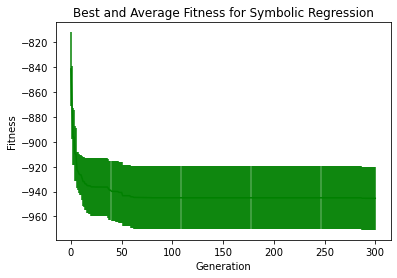

In [21]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListFitness)
minArray = numpy.array(minListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best and Average Fitness for Symbolic Regression')
#plt.errorbar(x, avgArray.mean(0), yerr=avgArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
plt.show()